Dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

## Requirements:

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [42]:
# LeNet was created by AT&T, named after Yann LeCun
# Image size is resized to 32x32, as per CIFAR10 size
# The first linear layer must be sized based on the size of the kernels, and the size of the images used to train/test after resizing

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5) # (32-5+0)/1 + 1 => 28 * 28 * 6
        self.maxpool1 = nn.MaxPool2d(2)
        # After pooling, 28/2 => 14 * 14 * 6
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5) # (14-5+0)/1 + 1 = 10 * 10 * 16
        self.maxpool2 = nn.MaxPool2d(2)
        # fully connected layers of size 120, 84 and 10
        # After pooling, 10/2 => 5 * 5 * 16
        self.flatten1 = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window        
        x = self.maxpool1(x)
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window        
        x = self.maxpool2(x)
        # Flatten spatial and depth dimensions into a single vector        
        x = self.flatten1(x)
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lenet = LeNet()
lenet.to(device)
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [43]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    final_loss_total = 0.0
    num_batches = 0
    success = 0
    counter = 0
    
    for i, data in enumerate(trainloader, 0):
        num_batches += 1
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data
        ip = ip.to(device)
        ground_truth = ground_truth.to(device)

        # zero the parameter gradients
        optim.zero_grad()

        op = net(ip) # forward pass        
        loss = nn.CrossEntropyLoss()(op, ground_truth) # get the loss
        loss.backward() # use loss to perform a backward pass
        optim.step() # optimisation step

        _, pred = torch.max(op.data, 1) # Get the predictions for purpose of accuracy
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

        # update loss
        final_loss_total += loss.item()        

    accuracy = 100 * success / counter
    print('[Epoch number : %d] accuracy: %.3f, loss: %.3f' % (epoch + 1, accuracy, final_loss_total / num_batches))
    return final_loss_total / num_batches, accuracy

def test(net, testloader, train_test="test"):
    success = 0
    counter = 0
    num_batches = 0
    loss_total = 0.0
    with torch.no_grad():
        for data in testloader:
            num_batches += 1
            im, ground_truth = data

            im = im.to(device)
            ground_truth = ground_truth.to(device)
            
            op = net(im)
            _, pred = torch.max(op.data, 1)
            loss = nn.CrossEntropyLoss()(op, ground_truth)
            # update loss
            loss_total += loss.item()
            
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    accuracy = 100 * success / counter
    print(f"LeNet accuracy on {len(testloader.dataset)} images from {train_test} dataset: {accuracy}. Loss: {loss_total / num_batches}")
    # Return loss
    return loss_total / num_batches, accuracy

In [44]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(32,32), antialias=True),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_dataset = torchvision.datasets.ImageFolder(root="catdog/training_set", transform=train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([transforms.Resize(size=(32,32), antialias=True), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_dataset = torchvision.datasets.ImageFolder(root="catdog/test_set", transform=test_transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

classes = ('cat', 'dog')

# Print labels
print(f"Number of training data items: {len(train_dataset)}") 
print(f"Number of test data items: {len(test_dataset)}") 
print(f"Number of cat labels in training: {sum(1 for i in train_dataset.targets if i == 0)}")
print(f"Number of dog labels in training: {sum(1 for i in train_dataset.targets if i == 1)}")
print(f"Number of cat labels in test: {sum(1 for i in test_dataset.targets if i == 0)}")
print(f"Number of dog labels in test: {sum(1 for i in test_dataset.targets if i == 1)}")

Number of training data items: 8005
Number of test data items: 2023
Number of cat labels in training: 4000
Number of dog labels in training: 4005
Number of cat labels in test: 1011
Number of dog labels in test: 1012


In [45]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

training_loss = []
training_acc = []
val_loss = []
val_acc = []
epochs = 100

# training loop over the dataset multiple times
for epoch in range(epochs):  
    t_loss, t_acc = train(lenet, trainloader, optim, epoch)        
    training_loss.append(t_loss)
    training_acc.append(t_acc)
    print() # Newline
    v_loss, v_acc = test(lenet, testloader)
    val_loss.append(v_loss)
    val_acc.append(v_acc)
    print()

# Save model for future use
model_path = './base_model_100_epoch.pth'
torch.save(lenet.state_dict(), model_path)

print('Finished Training')

[Epoch number : 1] accuracy: 53.167, loss: 0.745

LeNet accuracy on 2023 images from test dataset: 61.838853188334156. Loss: 0.6550438404083252

[Epoch number : 2] accuracy: 63.235, loss: 0.647

LeNet accuracy on 2023 images from test dataset: 66.33712308452793. Loss: 0.6199154853820801

[Epoch number : 3] accuracy: 67.745, loss: 0.604

LeNet accuracy on 2023 images from test dataset: 70.04448838358873. Loss: 0.5866639614105225

[Epoch number : 4] accuracy: 69.719, loss: 0.585

LeNet accuracy on 2023 images from test dataset: 71.13198220464656. Loss: 0.5702468156814575

[Epoch number : 5] accuracy: 70.531, loss: 0.572

LeNet accuracy on 2023 images from test dataset: 72.76322293623332. Loss: 0.5533899664878845

[Epoch number : 6] accuracy: 72.267, loss: 0.547

LeNet accuracy on 2023 images from test dataset: 69.00642609985171. Loss: 0.5884891748428345

[Epoch number : 7] accuracy: 73.304, loss: 0.534

LeNet accuracy on 2023 images from test dataset: 74.59218981710332. Loss: 0.535817742

0.014858036996231812 94
99.58775765146784 94
0.5169290900230408 13 74.44389520514088


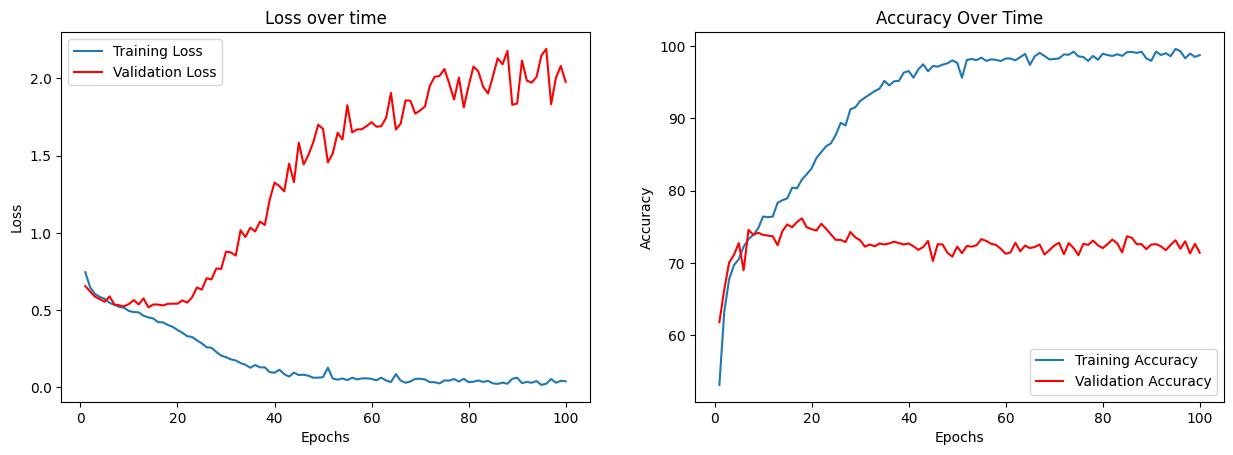

In [55]:
x_index = range(1, epochs+1, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

ax1.plot(x_index, training_loss, label="Training Loss")
ax1.plot(x_index, val_loss, color='red', label="Validation Loss")
ax1.set_title("Loss over time")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(x_index, training_acc, label="Training Accuracy")
ax2.plot(x_index, val_acc, color='red', label="Validation Accuracy")
ax2.legend()
ax2.set_title("Accuracy Over Time")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

print(np.min(training_loss), np.argmin(training_loss, axis=0))
print(np.max(training_acc), np.argmax(training_acc, axis=0))
print(np.min(val_loss), np.argmin(val_loss, axis=0), val_acc[np.argmin(val_loss, axis=0)])

## Next Steps:

- Doing a manual calculation of mean and std-dev of all RGB channels (after resizing), running a model on all the new values.
- No mean/std-dev, running a model
- Adding dropout (after one or both max-pooling layers) and early stopping
- More kernels
- Larger image
- Combined with all features known to help compared with base

In [56]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

Model accuracy on 2023 images from test dataset: 71.429 %


In [57]:
class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

# The model performs well on cats but only slightly better than random chance on dogs

Model accuracy for class   cat : 71.019 %
Model accuracy for class   dog : 71.838 %


In [35]:
train_transform = transforms.Compose([transforms.Resize(size=(32,32), antiahttps://www.geeksforgeeks.org/how-to-set-up-and-run-cuda-operations-in-pytorch/lias=True),
                                      transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(root="catdog/training_set", transform=train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

def batch_mean_and_sd(loader):    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std

mean, std = batch_mean_and_sd(trainloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.4882, 0.4551, 0.4174]) tensor([0.2441, 0.2371, 0.2398])


mean: ([0.4882, 0.4551, 0.4174]) std_dev: ([0.2441, 0.2371, 0.2398])


In [58]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(32,32), antialias=True),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.488, 0.455, 0.417), (0.244, 0.237, 0.240))])

train_dataset = torchvision.datasets.ImageFolder(root="catdog/training_set", transform=train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([transforms.Resize(size=(32,32), antialias=True), transforms.ToTensor(), transforms.Normalize((0.488, 0.455, 0.417), (0.244, 0.237, 0.240))])

test_dataset = torchvision.datasets.ImageFolder(root="catdog/test_set", transform=test_transform)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [59]:
lenet_modified = LeNet()
lenet_modified.to(device)
print(lenet_modified)

# define optimizer
optim = torch.optim.Adam(lenet_modified.parameters(), lr=0.001)

training_loss_mod1 = []
training_acc_mod1 = []
val_loss_mod1 = []
val_acc_mod1 = []
epochs = 100

# training loop over the dataset multiple times
for epoch in range(epochs):  
    t_loss, t_acc = train(lenet_modified, trainloader, optim, epoch)        
    training_loss_mod1.append(t_loss)
    training_acc_mod1.append(t_acc)
    print() # Newline
    v_loss, v_acc = test(lenet_modified, testloader)
    val_loss_mod1.append(v_loss)
    val_acc_mod1.append(v_acc)
    print()

# Save model for future use
model_path = './base_model_meancalculated_100_epoch.pth'
torch.save(lenet_modified.state_dict(), model_path)

print('Finished Training')

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[Epoch number : 1] accuracy: 54.216, loss: 0.744

LeNet accuracy on 2023 images from test dataset: 62.82748393475037. Loss: 0.6571271419525146

[Epoch number : 2] accuracy: 63.223, loss: 0.639

LeNet accuracy on 2023 images from test dataset: 66.38655462184875. Loss: 0.6264776587486267

[Epoch number : 3] accuracy: 66.184, loss: 0.612

LeNet accuracy on 2023 images from test dataset: 68.90756302521008. Loss: 0.5887894034385681

[Epoch number : 4] accuracy: 68.882,

0.011413828907587818 95
99.63772642098688 95
0.5092768669128418 14 75.53138902619871


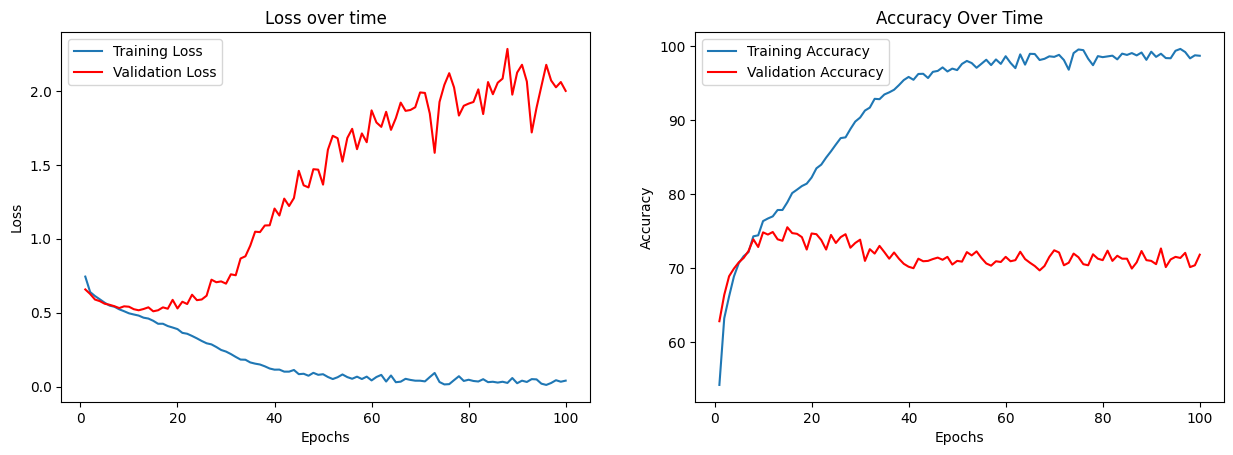

In [61]:
x_index = range(1, epochs+1, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

ax1.plot(x_index, training_loss_mod1, label="Training Loss")
ax1.plot(x_index, val_loss_mod1, color='red', label="Validation Loss")
ax1.set_title("Loss over time")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(x_index, training_acc_mod1, label="Training Accuracy")
ax2.plot(x_index, val_acc_mod1, color='red', label="Validation Accuracy")
ax2.legend()
ax2.set_title("Accuracy Over Time")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

print(np.min(training_loss_mod1), np.argmin(training_loss_mod1, axis=0))
print(np.max(training_acc_mod1), np.argmax(training_acc_mod1, axis=0))
print(np.min(val_loss_mod1), np.argmin(val_loss_mod1, axis=0), val_acc_mod1[np.argmin(val_loss_mod1, axis=0)])

In [62]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        
        op = lenet_modified(im)        
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print(f'Model accuracy on {len(testloader.dataset)} images from test dataset: %5.3f %%' % (100 * success / counter))

Model accuracy on 2023 images from test dataset: 71.824 %


In [63]:
class_success = list(0. for i in range(2))
class_counter = list(0. for i in range(2))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data

        # Move tensors to GPU for doing model testing
        im = im.to(device)
        
        op = lenet_modified(im)
        _, pred = torch.max(op, 1)

        # Move tensors back to CPU
        pred = pred.cpu()
        im = im.cpu()
        ground_truth = ground_truth.cpu()
        
        c = (pred == ground_truth).squeeze()
        for i in range(2023):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(2):
    print('Model accuracy for class %5s : %5.3f %%' % (classes[i], 100 * class_success[i] / class_counter[i]))

# The model performs well on cats but only slightly better than random chance on dogs

Model accuracy for class   cat : 74.085 %
Model accuracy for class   dog : 69.565 %
